# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [11]:
def create_densenet_model(architecture='121', num_classes=2, pretrained=True):
    """Create DenseNet model (121 or 169) for binary classification"""
    if architecture == '121':
        model = models.densenet121(pretrained=pretrained)
    elif architecture == '201':
        model = models.densenet201(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be '121' or '201'")
    
    # Modify classifier
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train DenseNet-121

Training DenseNet-121
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 192MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.38it/s, Loss=0.5177, Acc=0.8232]


Train Loss: 0.5177 Acc: 0.8232 Macro-F1: 0.7788


Val : 100%|██████████| 10/10 [00:01<00:00,  6.80it/s, Loss=0.9560, Acc=0.6711]


Val Loss: 0.9560 Acc: 0.6711 Macro-F1: 0.6291
✓ New best model saved with validation macro-F1: 0.6291

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.2326, Acc=0.9243]


Train Loss: 0.2326 Acc: 0.9243 Macro-F1: 0.8988


Val : 100%|██████████| 10/10 [00:01<00:00,  9.06it/s, Loss=0.9476, Acc=0.6875]


Val Loss: 0.9476 Acc: 0.6875 Macro-F1: 0.6449
✓ New best model saved with validation macro-F1: 0.6449

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.1822, Acc=0.9416]


Train Loss: 0.1822 Acc: 0.9416 Macro-F1: 0.9254


Val : 100%|██████████| 10/10 [00:01<00:00,  9.05it/s, Loss=0.2355, Acc=0.9178]


Val Loss: 0.2355 Acc: 0.9178 Macro-F1: 0.9160
✓ New best model saved with validation macro-F1: 0.9160

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.17it/s, Loss=0.1930, Acc=0.9301]


Train Loss: 0.1930 Acc: 0.9301 Macro-F1: 0.9110


Val : 100%|██████████| 10/10 [00:01<00:00,  8.38it/s, Loss=0.2743, Acc=0.9342]


Val Loss: 0.2743 Acc: 0.9342 Macro-F1: 0.9380
✓ New best model saved with validation macro-F1: 0.9380

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.16it/s, Loss=0.1399, Acc=0.9572]


Train Loss: 0.1399 Acc: 0.9572 Macro-F1: 0.9407


Val : 100%|██████████| 10/10 [00:01<00:00,  9.24it/s, Loss=0.5925, Acc=0.8026]


Val Loss: 0.5925 Acc: 0.8026 Macro-F1: 0.8008

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.10it/s, Loss=0.0766, Acc=0.9729]


Train Loss: 0.0766 Acc: 0.9729 Macro-F1: 0.9698


Val : 100%|██████████| 10/10 [00:01<00:00,  9.19it/s, Loss=0.0635, Acc=0.9704]


Val Loss: 0.0635 Acc: 0.9704 Macro-F1: 0.9665
✓ New best model saved with validation macro-F1: 0.9665

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.16it/s, Loss=0.0331, Acc=0.9910]


Train Loss: 0.0331 Acc: 0.9910 Macro-F1: 0.9902


Val : 100%|██████████| 10/10 [00:01<00:00,  8.98it/s, Loss=0.0813, Acc=0.9671]


Val Loss: 0.0813 Acc: 0.9671 Macro-F1: 0.9607

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.0296, Acc=0.9918]


Train Loss: 0.0296 Acc: 0.9918 Macro-F1: 0.9899


Val : 100%|██████████| 10/10 [00:01<00:00,  9.11it/s, Loss=0.0166, Acc=0.9934]


Val Loss: 0.0166 Acc: 0.9934 Macro-F1: 0.9948
✓ New best model saved with validation macro-F1: 0.9948

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.13it/s, Loss=0.0096, Acc=0.9984]


Train Loss: 0.0096 Acc: 0.9984 Macro-F1: 0.9986


Val : 100%|██████████| 10/10 [00:01<00:00,  8.83it/s, Loss=0.0102, Acc=0.9967]


Val Loss: 0.0102 Acc: 0.9967 Macro-F1: 0.9974
✓ New best model saved with validation macro-F1: 0.9974

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.0123, Acc=0.9967]


Train Loss: 0.0123 Acc: 0.9967 Macro-F1: 0.9974


Val : 100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Loss=0.0077, Acc=1.0000]


Val Loss: 0.0077 Acc: 1.0000 Macro-F1: 1.0000
✓ New best model saved with validation macro-F1: 1.0000

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.16it/s, Loss=0.0061, Acc=1.0000]


Train Loss: 0.0061 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.06it/s, Loss=0.0083, Acc=0.9967]


Val Loss: 0.0083 Acc: 0.9967 Macro-F1: 0.9974

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.17it/s, Loss=0.0048, Acc=1.0000]


Train Loss: 0.0048 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.00it/s, Loss=0.0096, Acc=0.9967]


Val Loss: 0.0096 Acc: 0.9967 Macro-F1: 0.9974

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.09it/s, Loss=0.0045, Acc=1.0000]


Train Loss: 0.0045 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.02it/s, Loss=0.0067, Acc=0.9967]


Val Loss: 0.0067 Acc: 0.9967 Macro-F1: 0.9974

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.15it/s, Loss=0.0047, Acc=0.9992]


Train Loss: 0.0047 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  8.99it/s, Loss=0.0069, Acc=0.9967]


Val Loss: 0.0069 Acc: 0.9967 Macro-F1: 0.9974

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.16it/s, Loss=0.0034, Acc=1.0000]


Train Loss: 0.0034 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  9.17it/s, Loss=0.0082, Acc=0.9967]


Val Loss: 0.0082 Acc: 0.9967 Macro-F1: 0.9974
Early stopping triggered after 15 epochs
Training complete in 2m 11s
Best validation macro-F1: 1.0000


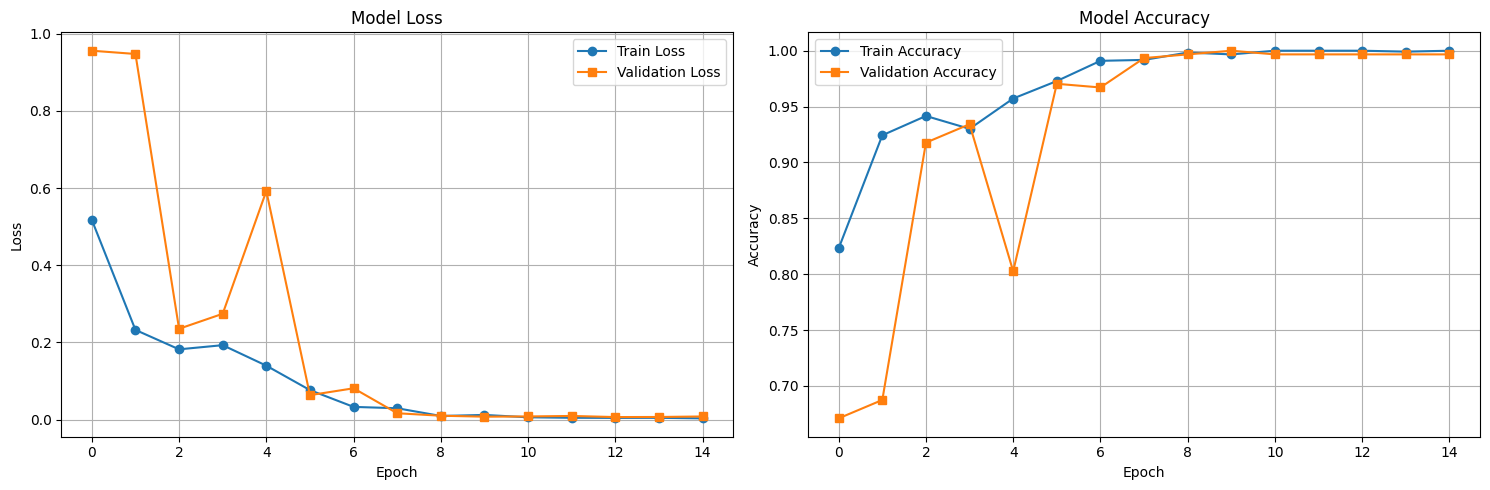

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


Test Accuracy: 35.98%
Test Loss: 2.3365

Classification Report:
              precision    recall  f1-score   support

         HGC       0.41      0.22      0.28        74
         LGC       0.11      0.11      0.11        53
         NST       0.59      0.73      0.65        37
         NTL       0.40      0.76      0.53        25

    accuracy                           0.36       189
   macro avg       0.38      0.45      0.39       189
weighted avg       0.36      0.36      0.34       189


Confusion Matrix:
[[16 51  4  3]
 [23  6  9 15]
 [ 0  0 27 10]
 [ 0  0  6 19]]

ROC-AUC Scores:
Macro-average AUC: 0.7173
Micro-average AUC: 0.6743
HGC AUC: 0.6881
LGC AUC: 0.4413
NST AUC: 0.8474
NTL AUC: 0.8922


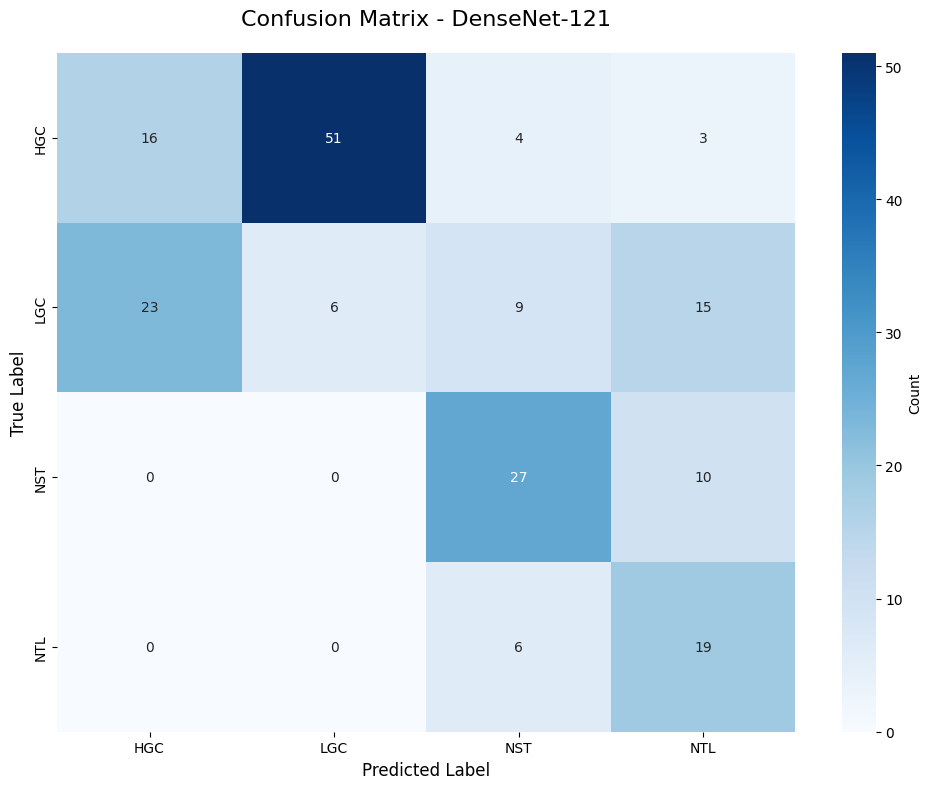

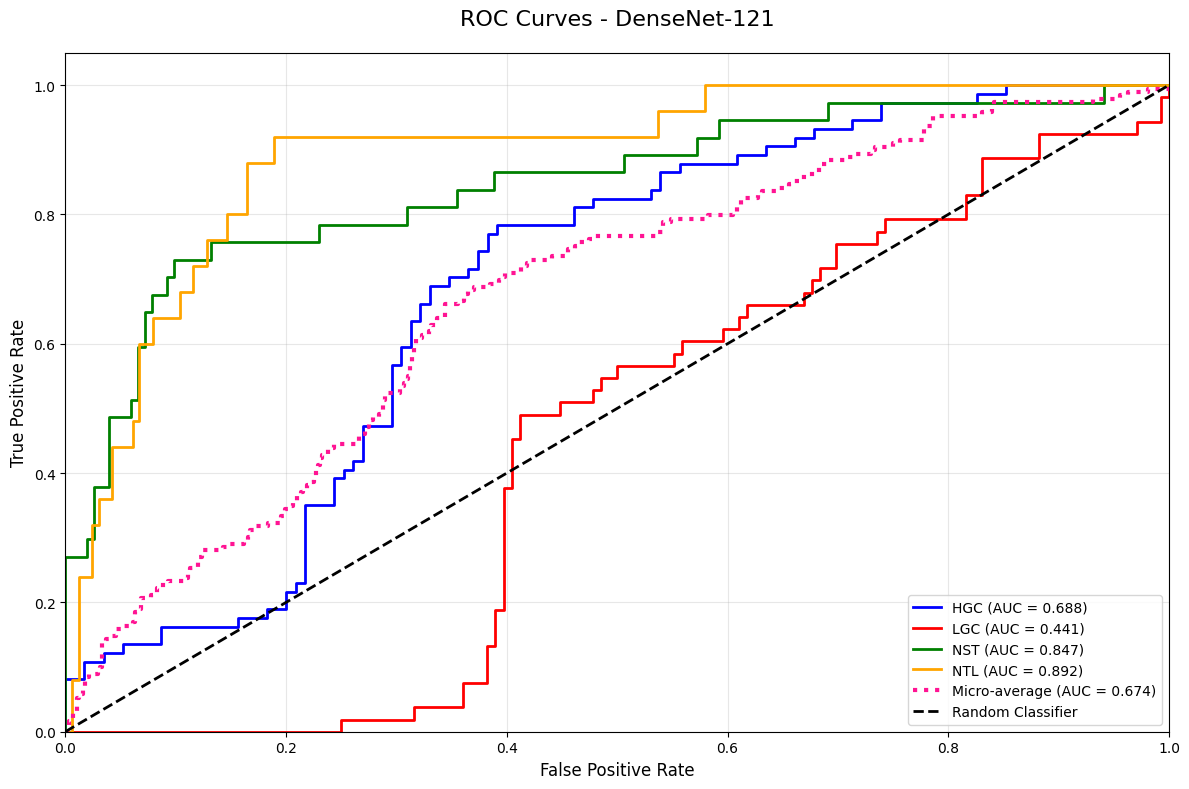


DenseNet-121 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training DenseNet-121")
print("=" * 80)

# Create model
densenet121 = create_densenet_model(architecture='121', num_classes=4, pretrained=True)

# Create trainer
trainer_121 = ModelTrainer(densenet121, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_50 = trainer_121.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DenseNet-121")

# Plot training history
trainer_121.plot_training_history(save_path='densenet121_training_history.png')

# Evaluate model
results_121 = trainer_121.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_121['confusion_matrix'], class_names, 'DenseNet-121',
                      save_path='densenet121_confusion_matrix.png')

# Plot ROC curves
roc_auc_121 = plot_roc_curves(results_121['labels'], results_121['probabilities'], class_names, 'DenseNet-121',
                              save_path='densenet121_roc_curves.png')
# Store results
results_121['model_name'] = 'DenseNet-121'
results_121['roc_auc'] = roc_auc_121
all_results.append(results_121)

print("\nDenseNet-121 training and evaluation complete!")

## Train DenseNet-201

Training DenseNet-201


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 228MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.23it/s, Loss=0.6657, Acc=0.7533]


Train Loss: 0.6657 Acc: 0.7533 Macro-F1: 0.7009


Val : 100%|██████████| 10/10 [00:01<00:00,  6.97it/s, Loss=5.2546, Acc=0.5329]


Val Loss: 5.2546 Acc: 0.5329 Macro-F1: 0.3977
✓ New best model saved with validation macro-F1: 0.3977

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.28it/s, Loss=0.3063, Acc=0.9005]


Train Loss: 0.3063 Acc: 0.9005 Macro-F1: 0.8714


Val : 100%|██████████| 10/10 [00:01<00:00,  7.03it/s, Loss=0.5772, Acc=0.8257]


Val Loss: 0.5772 Acc: 0.8257 Macro-F1: 0.7633
✓ New best model saved with validation macro-F1: 0.7633

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.2552, Acc=0.9186]


Train Loss: 0.2552 Acc: 0.9186 Macro-F1: 0.8877


Val : 100%|██████████| 10/10 [00:01<00:00,  7.13it/s, Loss=1.4320, Acc=0.7105]


Val Loss: 1.4320 Acc: 0.7105 Macro-F1: 0.6637

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.1874, Acc=0.9326]


Train Loss: 0.1874 Acc: 0.9326 Macro-F1: 0.9225


Val : 100%|██████████| 10/10 [00:01<00:00,  7.13it/s, Loss=0.0961, Acc=0.9671]


Val Loss: 0.0961 Acc: 0.9671 Macro-F1: 0.9621
✓ New best model saved with validation macro-F1: 0.9621

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.1841, Acc=0.9441]


Train Loss: 0.1841 Acc: 0.9441 Macro-F1: 0.9245


Val : 100%|██████████| 10/10 [00:01<00:00,  7.13it/s, Loss=0.1937, Acc=0.9441]


Val Loss: 0.1937 Acc: 0.9441 Macro-F1: 0.9291

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0779, Acc=0.9737]


Train Loss: 0.0779 Acc: 0.9737 Macro-F1: 0.9691


Val : 100%|██████████| 10/10 [00:01<00:00,  7.01it/s, Loss=0.0744, Acc=0.9770]


Val Loss: 0.0744 Acc: 0.9770 Macro-F1: 0.9699
✓ New best model saved with validation macro-F1: 0.9699

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.28it/s, Loss=0.0473, Acc=0.9762]


Train Loss: 0.0473 Acc: 0.9762 Macro-F1: 0.9760


Val : 100%|██████████| 10/10 [00:01<00:00,  7.07it/s, Loss=0.1095, Acc=0.9539]


Val Loss: 0.1095 Acc: 0.9539 Macro-F1: 0.9588

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0329, Acc=0.9885]


Train Loss: 0.0329 Acc: 0.9885 Macro-F1: 0.9886


Val : 100%|██████████| 10/10 [00:01<00:00,  6.86it/s, Loss=0.0161, Acc=0.9934]


Val Loss: 0.0161 Acc: 0.9934 Macro-F1: 0.9948
✓ New best model saved with validation macro-F1: 0.9948

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0085, Acc=0.9984]


Train Loss: 0.0085 Acc: 0.9984 Macro-F1: 0.9987


Val : 100%|██████████| 10/10 [00:01<00:00,  7.14it/s, Loss=0.0144, Acc=0.9934]


Val Loss: 0.0144 Acc: 0.9934 Macro-F1: 0.9948
✓ New best model saved with validation macro-F1: 0.9948

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.26it/s, Loss=0.0084, Acc=0.9984]


Train Loss: 0.0084 Acc: 0.9984 Macro-F1: 0.9975


Val : 100%|██████████| 10/10 [00:01<00:00,  7.07it/s, Loss=0.0123, Acc=0.9934]


Val Loss: 0.0123 Acc: 0.9934 Macro-F1: 0.9948

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0059, Acc=0.9984]


Train Loss: 0.0059 Acc: 0.9984 Macro-F1: 0.9988


Val : 100%|██████████| 10/10 [00:01<00:00,  7.11it/s, Loss=0.0116, Acc=0.9934]


Val Loss: 0.0116 Acc: 0.9934 Macro-F1: 0.9948

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0049, Acc=1.0000]


Train Loss: 0.0049 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  7.10it/s, Loss=0.0097, Acc=0.9934]


Val Loss: 0.0097 Acc: 0.9934 Macro-F1: 0.9948

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0059, Acc=0.9992]


Train Loss: 0.0059 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  7.00it/s, Loss=0.0112, Acc=0.9934]


Val Loss: 0.0112 Acc: 0.9934 Macro-F1: 0.9948

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.28it/s, Loss=0.0066, Acc=0.9992]


Train Loss: 0.0066 Acc: 0.9992 Macro-F1: 0.9982


Val : 100%|██████████| 10/10 [00:01<00:00,  7.09it/s, Loss=0.0098, Acc=0.9967]


Val Loss: 0.0098 Acc: 0.9967 Macro-F1: 0.9974
✓ New best model saved with validation macro-F1: 0.9974

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0049, Acc=1.0000]


Train Loss: 0.0049 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  6.81it/s, Loss=0.0087, Acc=0.9967]


Val Loss: 0.0087 Acc: 0.9967 Macro-F1: 0.9974

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0053, Acc=0.9992]


Train Loss: 0.0053 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  6.92it/s, Loss=0.0086, Acc=0.9967]


Val Loss: 0.0086 Acc: 0.9967 Macro-F1: 0.9974

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0042, Acc=1.0000]


Train Loss: 0.0042 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  7.06it/s, Loss=0.0084, Acc=0.9967]


Val Loss: 0.0084 Acc: 0.9967 Macro-F1: 0.9974

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.27it/s, Loss=0.0049, Acc=0.9992]


Train Loss: 0.0049 Acc: 0.9992 Macro-F1: 0.9992


Val : 100%|██████████| 10/10 [00:01<00:00,  7.07it/s, Loss=0.0077, Acc=0.9967]


Val Loss: 0.0077 Acc: 0.9967 Macro-F1: 0.9974

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.28it/s, Loss=0.0048, Acc=0.9992]


Train Loss: 0.0048 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  7.02it/s, Loss=0.0081, Acc=0.9967]


Val Loss: 0.0081 Acc: 0.9967 Macro-F1: 0.9974
Early stopping triggered after 19 epochs
Training complete in 4m 11s
Best validation macro-F1: 0.9974


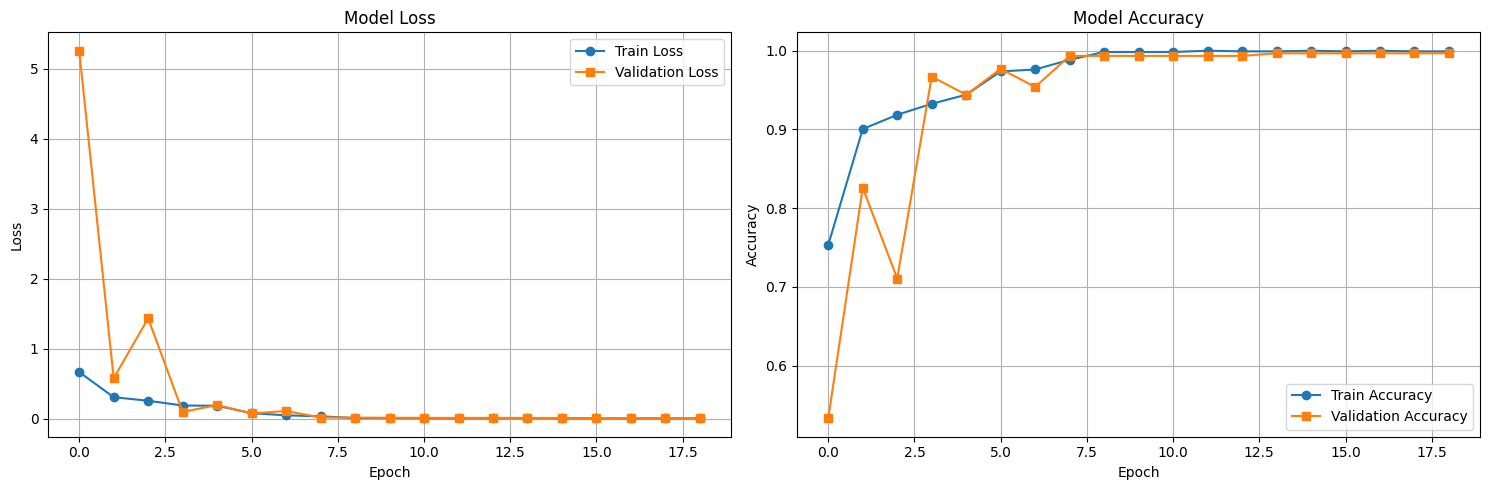

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


Test Accuracy: 45.50%
Test Loss: 2.1275

Classification Report:
              precision    recall  f1-score   support

         HGC       0.48      0.43      0.46        74
         LGC       0.25      0.25      0.25        53
         NST       0.61      0.68      0.64        37
         NTL       0.52      0.64      0.57        25

    accuracy                           0.46       189
   macro avg       0.47      0.50      0.48       189
weighted avg       0.45      0.46      0.45       189


Confusion Matrix:
[[32 30 12  0]
 [33 13  1  6]
 [ 1  2 25  9]
 [ 0  6  3 16]]

ROC-AUC Scores:
Macro-average AUC: 0.6773
Micro-average AUC: 0.6773
HGC AUC: 0.5468
LGC AUC: 0.4480
NST AUC: 0.8668
NTL AUC: 0.8476


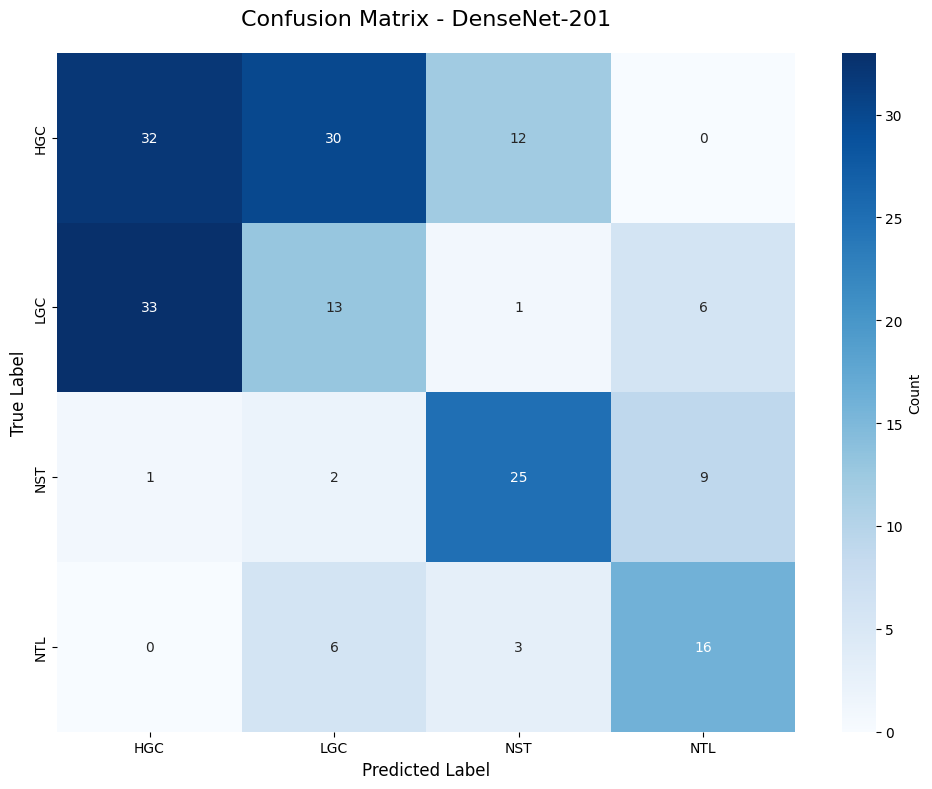

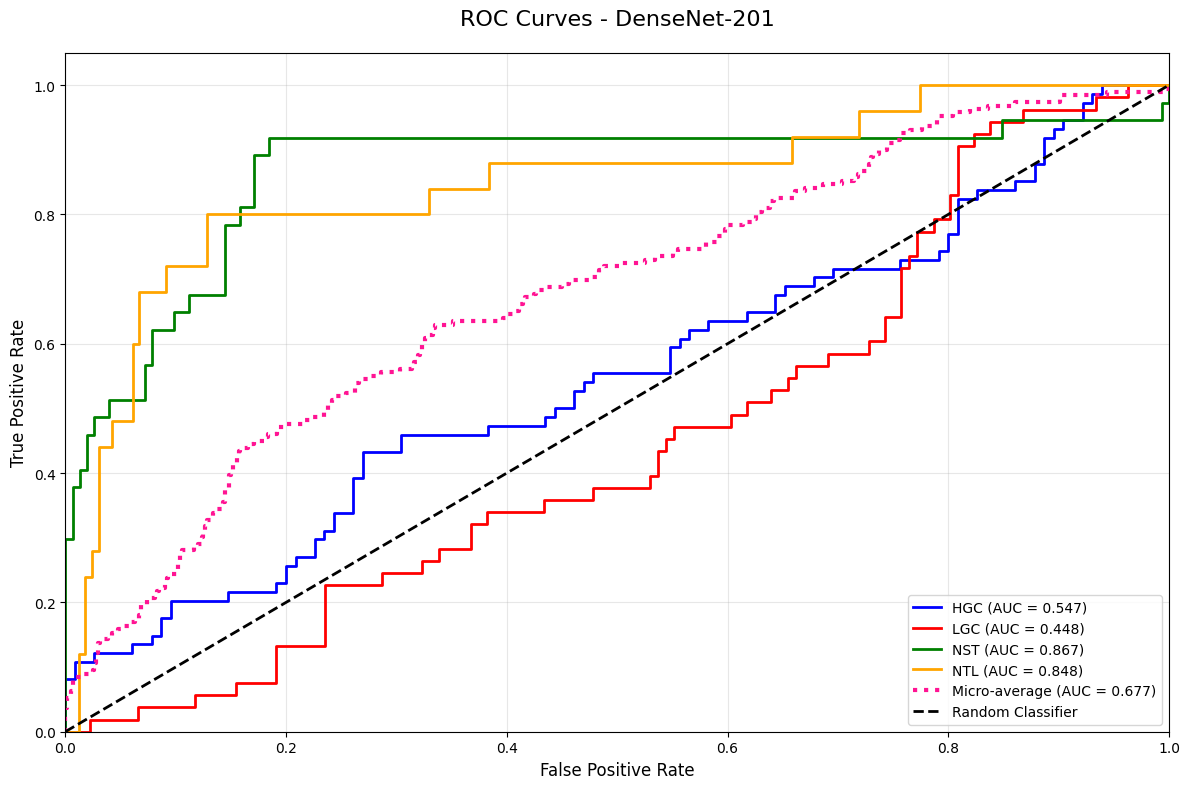


DenseNet-201 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training DenseNet-201")
print("=" * 80)

# Create model
densenet201 = create_densenet_model(architecture='201', num_classes=4, pretrained=True)

# Create trainer
trainer_201 = ModelTrainer(densenet201, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_201 = trainer_201.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="densenet201")

# Plot training history
trainer_201.plot_training_history(save_path='densenet201_training_history.png')

# Evaluate model
results_201 = trainer_201.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_201['confusion_matrix'], class_names, 'DenseNet-201',
                      save_path='densenet201_confusion_matrix.png')

# Plot ROC curves
roc_auc_201 = plot_roc_curves(results_201['labels'], results_201['probabilities'], class_names, 'DenseNet-201',
                               save_path='Densenet201_roc_curves.png')
# Store results
results_201['model_name'] = 'DenseNet-201'
results_201['roc_auc'] = roc_auc_201
all_results.append(results_201)

print("\nDenseNet-201 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'DenseNet-121_201.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: DenseNet-121_201.csv

Metrics Summary:
          Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  DenseNet-121         35.978836      2.336465             0.376683          0.454788      0.392664                0.358527             0.359788         0.338647       0.410256    0.216216  0.283186         74.0       0.105263    0.113208  0.109091         53.0       0.586957    0.729730  0.650602         37.0       0.404255        0.76  0.527778         25.0   0.717270   0.674309  0.688132  0.441315  0.847440  0.892195      0.688132   